# Own Document Similarity Search API
This API embeds a user-provided document (title and abstract) and searches for similar documents in specified indices, returning the top matches and their similarity scores.


In [8]:
import pandas as pd
import requests
from dotenv import dotenv_values


# Load environment variables from .env file
conf = dotenv_values()
API_KEY = conf["API_KEY"]

# Choose model to encode the document: patspecter, specter2 (only for publications) or paecter (only for patents)
model = "patspecter"

In [9]:
# API Settings
URL = 'https://api.logic-mill.net/api/v1/graphql/'
headers = {
    'content-type': 'application/json',
    'Authorization': 'Bearer ' + API_KEY,
}

# Build GraphQL query
query = """query embedDocumentAndSimilaritySearch($data: [EncodeDocumentPart], $indices: [String], $amount: Int, $model: String!) { encodeDocumentAndSimilaritySearch(data: $data indices: $indices amount: $amount model: $model) { id score index document { title url PatspecterEmbedding } } }"""

# Input data for the query
title = "Attaining Carnot efficiency with quantum and nanoscale heat engines"
abstract = "A heat engine operating in the one-shot finite-size regime, where systems composed of a small number of quantum particles interact with hot and cold baths and are restricted to one-shot measurements, delivers fluctuating work. Further, engines with lesser fluctuation produce a lesser amount of deterministic work. Hence, the heat-to-work conversion efficiency stays well below the Carnot efficiency. Here we overcome this limitation and attain Carnot efficiency in the one-shot finite-size regime, where the engines allow the working systems to simultaneously interact with two baths via the semi-local thermal operations and reversibly operate in a one-step cycle. These engines are superior to the ones considered earlier in work extraction efficiency, and, even, are capable of converting heat into work by exclusively utilizing inter-system correlations. We formulate a resource theory for quantum heat engines to prove the results."
amount_results = 5    # Number of results per document type
document_types = ["patents", "publications"]

# Build variables for the query
variables = {
  "model": model,
  "data": [
    {
      "key": "title",
      "value": title
    },
    {
      "key": "abstract",
      "value": abstract
    }
  ],
  "amount": amount_results,
  "indices": document_types
}

In [10]:
# Send a POST request to the API
response = requests.post(URL, headers=headers, json={'query': query , 'variables': variables})

In [11]:
# Handle response
if not response.ok:
    raise Exception(f"Error: {response.status_code} - {response.text}")

json_response = response.json()
documents = json_response["data"]["encodeDocumentAndSimilaritySearch"]
df = pd.json_normalize(documents)
df.head()

,id,index,score,document.PatspecterEmbedding,document.title,document.url
0,W3130812041,publications,0.999393,"[-0.02372956, -0.319943, 0.30027115, 0.7557934...",Attaining Carnot efficiency with quantum and n...,https://openalex.org/works/W3130812041
1,W3170098071,publications,0.994297,"[0.0197368, -0.04091401, 0.33053038, 0.9049551...",Quantum heat engines with Carnot efficiency at...,https://openalex.org/works/W3170098071
2,W2985448335,publications,0.991672,"[0.07504982, -0.20513703, 0.21314219, 0.736508...",The Second Laws for Quantum and Nano-scale Hea...,https://openalex.org/works/W2985448335
3,W3101954860,publications,0.990555,"[0.06475695, 0.1950768, 0.32974538, 1.0288727,...",Quantum supremacy of many-particle thermal mac...,https://openalex.org/works/W3101954860
4,W2171462260,publications,0.989534,"[-0.13036907, -0.1514624, 0.14942288, 0.666821...",Construction and optimization of a quantum ana...,https://openalex.org/works/W2171462260


## 2D PCA Scatterplots for Patents and Publications

The following visualizations show the 2D PCA projections of the document embeddings, separated by document type (patents and publications). Each point represents a document, with its ID shown in bold and its similarity score displayed below the point. The 2D PCA can be used to visually assess how similar or distinct the documents are within and across categories, and to identify patterns or clusters in the embedding space.

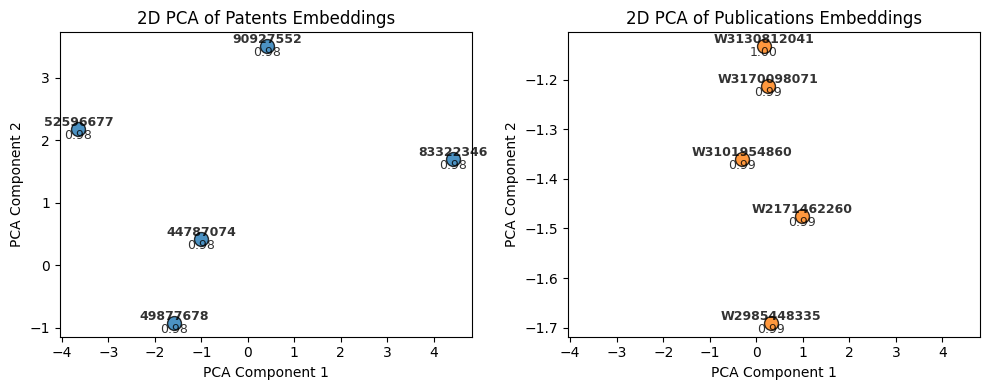

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# Extract embeddings and convert to numpy array
embeddings = np.vstack(df['document.PatspecterEmbedding'].values)
ids = df['id'].values
scores = df['score'].values
indices = df['index'].values

# Reduce embeddings to 2D
pca = PCA(n_components=2)
X_2d = pca.fit_transform(embeddings)

# Prepare side-by-side plots (no shared y-axis)
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
doc_types = ['patents', 'publications']

for ax, doc_type in zip(axes, doc_types):
    mask = indices == doc_type
    color = plt.cm.tab10(0 if doc_type == 'patents' else 1)
    scatter = ax.scatter(X_2d[mask, 0], X_2d[mask, 1], s=100, edgecolor='k', alpha=0.8, color=color)
    for i, (x, y) in enumerate(X_2d[mask]):
        ax.annotate(f"{ids[mask][i]}", (x, y), fontsize=9, alpha=0.8, ha='center', va='bottom', fontweight='bold')
        ax.annotate(f"{scores[mask][i]:.2f}", (x, y), fontsize=9, alpha=0.8, ha='center', va='top')
    ax.set_title(f"2D PCA of {doc_type.capitalize()} Embeddings")
    ax.set_xlabel("PCA Component 1")
    ax.set_ylabel("PCA Component 2")

plt.tight_layout()
plt.show()